<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h3 style="text-align: right;">Tarea 1 - Parte 2</h3>
    </div>
    <img src="Figures\logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

### Ejercicio 1
Retomamos el ejercicio 2 de la parte 1. Agrega a la imagen elegida ruido gausiano (es decir, suma a los niveles de gris valores provenientes de distribuciones independientes $\mathcal{N}(0; \sigma^2)$. Muestra cómo la aproximación
obtenida con SVD y limitándose a $p$, con $p$ elegido apropiadamente, permite obtener una imagen filtrada que aproxima la imagen original.

Una variante es aplicar la idea de parches: dividimos la imagen original en subimágenes de tamaño $k \times k$; Consideramos cada parche como una observación en forma de vector y aplicamos PCA. Compara los resultados con el método global.

En esta ocasión, agregamos ruido a la imagen al importarla.

In [1]:
# libraries
from matplotlib.image import imread, imsave
import matplotlib.pyplot as plt
import numpy as np

# functions to load and show images (rgb to grayscale)
def load_image(path):
    im = imread(path)
    X = im.dot([0.299, 0.5870, 0.114]) # to grayscale
    noise = np.random.normal(0, 60, X.shape)  # Add Gaussian noise with mean 0 and std 40
    X += noise
    return X

def show_image(X, title):
    plt.figure(figsize=(9, 6))
    plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

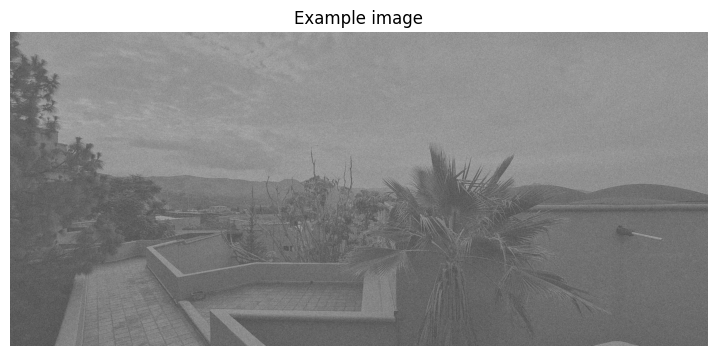

In [2]:
image = load_image("C:/Users/micke/Documents/Python/Patrones/Tarea 1/foto.jpg")
show_image(image, "Example image")
imsave("original.png", image, cmap='gray')

Para ver los efectos de la descomposición SVD tomando los primeros $p$ vectores en la descomposición.

In [3]:
def svd_effect(image, p):
    U, S, V = np.linalg.svd(image, full_matrices=False) # decomposition
    image_p =  (U[:,:p] * S[:p]) @ V[:p,:] # reconstruction using first p components
    error_p = (np.linalg.norm(image - image_p, 'fro') / np.linalg.norm(image, 'fro')) ** 2 # reconstruction error
    return image_p, error_p

Aplicamos el método de SVD a la imagen y mostramos los resultados para diferentes valores de $p$. Además, calculamos el error de reconstrucción para cada valor de $p$ y lo imprimimos en pantalla.

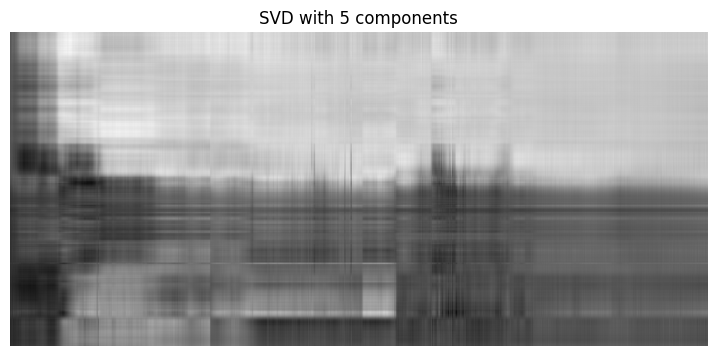

Error for 5 components: 0.16516861243036712


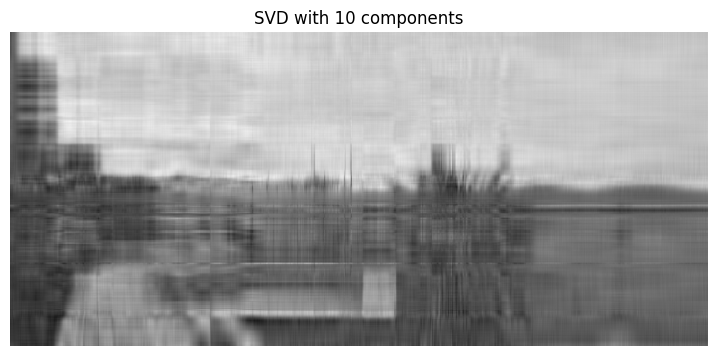

Error for 10 components: 0.15879653495954085


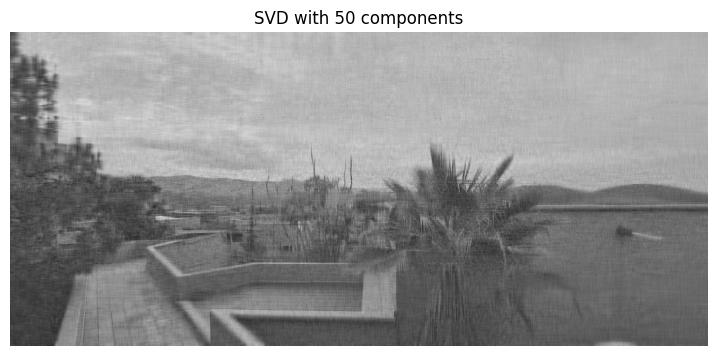

Error for 50 components: 0.14502740530785324


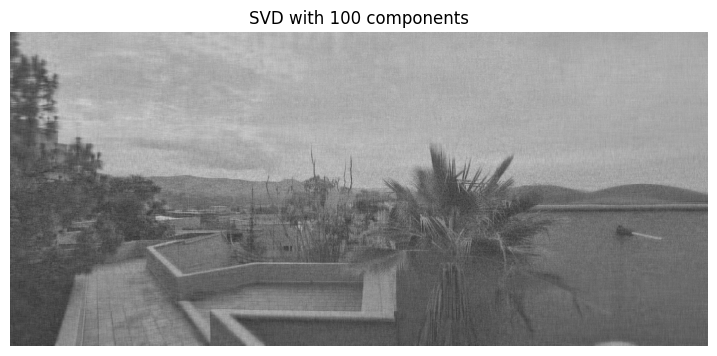

Error for 100 components: 0.13416136296502643


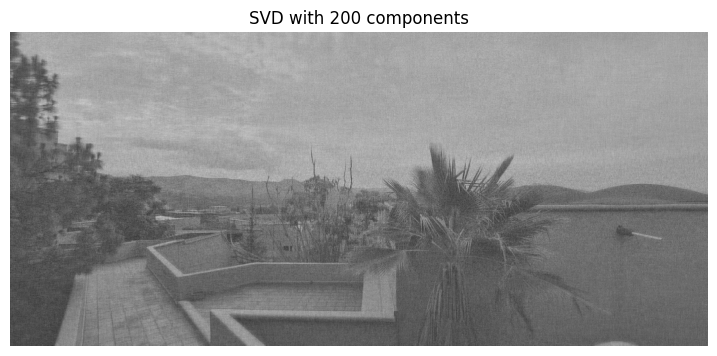

Error for 200 components: 0.11538797540113416


In [4]:
P = [5, 10, 50, 100, 200]
for p in P:
    image_p, error_p = svd_effect(image, p)
    show_image(image_p, title=f"SVD with {p} components")
    print(f"Error for {p} components: {error_p}")

Hacemos el mismo procedimiento, pero utilizando descomposición SVD en bloques de tamaño $k$ por $k$, y tomando los primeros $p$ vectores en la descomposición de cada bloque.

In [5]:
def svd_on_blocks(image, p, k):
    h, w = image.shape
    
    # We will apply a padding to the image so that it can be divided into kxk blocks without losing information.
    # Adjust image dimensions to be divisible by k
    h_adj = (h + k - 1) // k * k
    w_adj = (w + k - 1) // k * k
    
    image_pad = np.pad(image, ((0, h_adj - h), (0, w_adj - w)), mode='edge')
    
    blocks = []
    for i in range(0, h_adj, k):
        for j in range(0, w_adj, k):
            blocks.append(image_pad[i:i+k, j:j+k].flatten())
    
    # Apply SVD effect on auxiliary matrix
    aux_p, _ = svd_effect(np.array(blocks).T, p)
    
    # Reconstruct blocks from modified auxiliary matrix
    reconstructed_blocks = aux_p.T.reshape(-1, k, k)
    
    # Rebuild the original image from blocks
    reconstructed_image = np.zeros((h_adj, w_adj))
    idx = 0
    for i in range(0, h_adj, k):
        for j in range(0, w_adj, k):
            reconstructed_image[i:i+k, j:j+k] = reconstructed_blocks[idx]
            idx += 1
    error = (np.linalg.norm(image - reconstructed_image[:h, :w], 'fro') / np.linalg.norm(image, 'fro')) ** 2 # reconstruction error
    return reconstructed_image[:h, :w], error


Aplicamos el método de SVD por bloques a la imagen con $k=15$ y mostramos los resultados para diferentes valores de $p$. Además, calculamos el error de reconstrucción para cada valor de $p$ y lo imprimimos en pantalla.

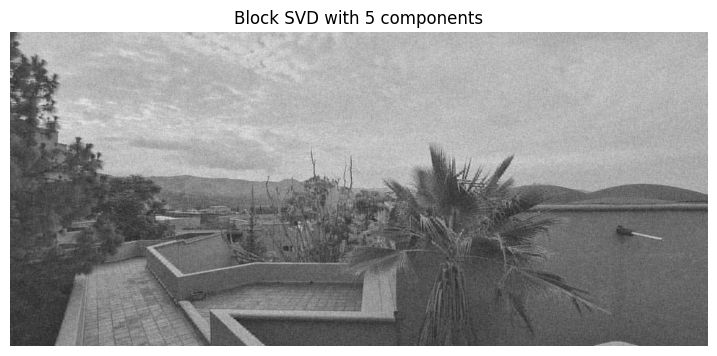

Error for 5 components: 0.14717116714780856


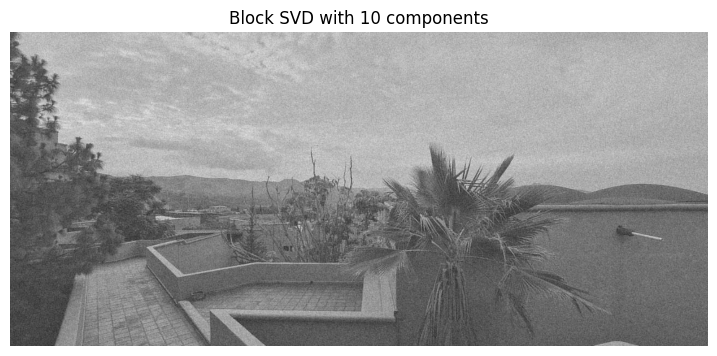

Error for 10 components: 0.14190365153216372


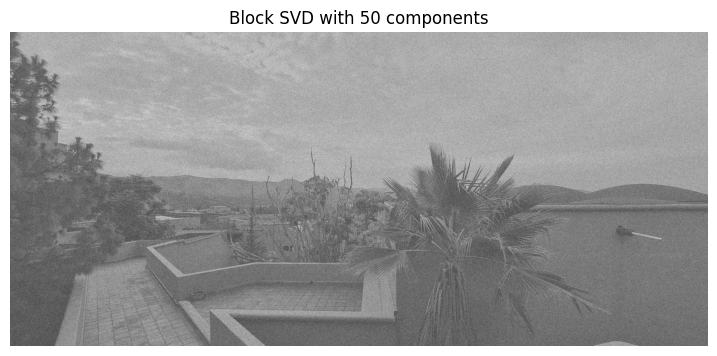

Error for 50 components: 0.11123540039431479


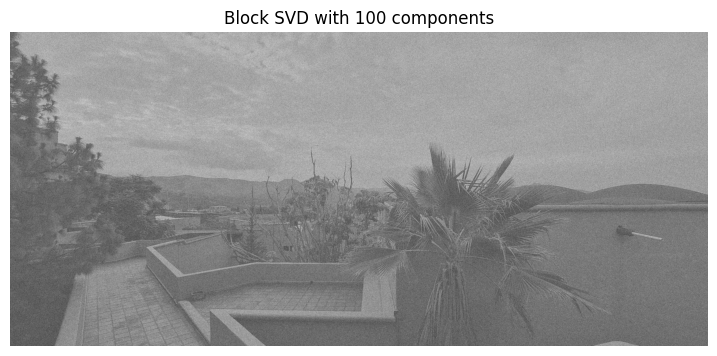

Error for 100 components: 0.07671817409066099


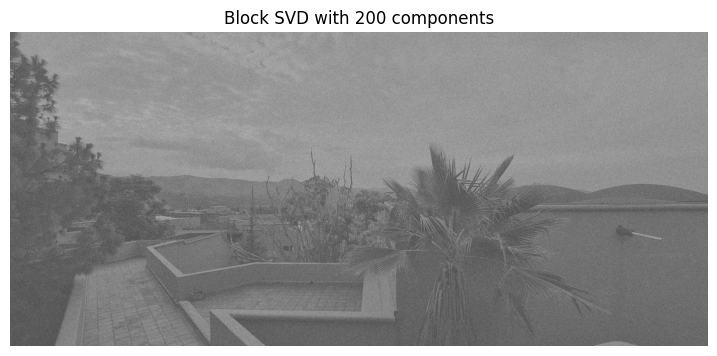

Error for 200 components: 0.014202094505541133


In [6]:
for p in P:
    image_p, error_p = svd_on_blocks(image, p, k=15)
    show_image(image_p, title=f"Block SVD with {p} components")
    print(f"Error for {p} components: {error_p}")


El método de SVD por bloques funciona mucho mejor que el original, incluso para $p=10$ y $p=50$, el ruido se reduce con respecto a la imagen original con ruido. Podemos concluir que este método funciona muy bien.

### Ejercicio 2
Considera los datos oef2.data. Se trata de los promedios mensuales de la temperatura (en Celsius) en 35 estaciones canadienses de monitoreo. El interés es comparar las estaciones entre sí en base de sus curvas de
temperatura.

Considerando las 12 mediciones por estación como un vector $X$, aplica un análisis de componentes principales. Como $X$ representa (un muestreo de) una curva, este tipo de datos se llama datos funcionales. Interpreta y dibuja (como curva) los primeros dos componentes, $l_1; l_2$ es decir grafica $\{(i; l1_i)\}$ y $\{(i; l2_i)\}$. Agrupa e interpreta las estaciones en el biplot (ten en mente un mapa de Canada).

Iniciamos con la importación de las librerías necesarias y el cargado del dataset

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimpy import skim
import seaborn as sns

In [8]:
d = pd.read_csv('oef2.csv',index_col=0)

In [9]:
d.head()

,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
Nombre,,,,,,,,,,,,
St. John_s,-3.9,-4.5,-2.3,1.2,5.4,10.9,15.5,15.3,11.6,6.9,3.4,-1.5
Charlottetown,-7.1,-7.5,-3.1,2.3,8.5,14.5,18.3,17.8,13.5,8.1,2.9,-3.9
Halifax,-6.0,-6.1,-1.6,3.3,9.2,14.8,18.2,18.1,13.8,8.6,3.4,-2.9
Sydney,-4.7,-5.9,-2.5,2.0,7.4,13.2,17.7,17.6,13.5,8.4,3.8,-1.8
Yarmouth,-2.7,-3.2,0.3,4.7,9.2,13.4,16.3,16.4,13.6,9.5,5.2,-0.3


Previo al Análisis de Componentes Prinrincipales (PCA), exploremos los datostos con un resumen estadístico de lo que nos proporciona la librería skimpy

In [10]:
skim(d)


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 35     │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 12     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column        ┃ NA  ┃ NA %   ┃ mean     ┃ sd      ┃ p0      ┃ p25      ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ Enero         │   0 │      0 │   -14.17 │   9.655 │   -32.1 │    -21.1 │  -12.1 │  -6.65 │   4.1 │ ▅▅▇▇▇▃  │  │
│ │ Febrero       │   0 │      0 │   -11.84 │   9.236 │   -33.2 │   -16.35 │  -10.8 │   -6.1 │   5.8 │ ▁▃▂▇▅▂  │  │
│ │ Marzo         │   0 │      0 │   -6.943 │   8.636 │   -31.4 │    -9.85 │   -4.5 │  -2.05 │   6.7 │ ▁▂▁▅▇▂  │  │
│ │ Abril         │   0 │      0 │      0.9 │   7.083 │   -23.1 │      0.4 │    3.2 │    4.5 │   9.1 │  ▁▁ ▇▅  │  │
│ │ Mayo          │   0 │      0 │    7.974 │   5.246 │   -10.9 │      7.5 │    9.3 │  10.95 │  14.1 │ ▁▁▂▁▇▇  │  │
│ │ Junio         │   0 │      0 │    13.43 │    4.05 │    -0.6 │     12.9 │   14.1 │   15.9 │  18.3 │   ▁▂▇▆  │  │
│ │ Julio         │   0 │      0 │    16.44 │    3.59 │     4.1 │     15.3 │   17.3 │  18.65 │  20.9 │ ▁▁▁▃▇▇  │  │
│ │ Agosto        │   0 │      0 │    15.35 │   3.702 │     2.4 │     14.1 │   16.1 │   17.8 │  19.8 │ ▁▁▁▂▇▇  │  │
│ │ Septiembre    │   0 │      0 │    10.45 │   4.355 │    -5.1 │      9.6 │   11.6 │  13.55 │  15.5 │ ▁ ▂▂▆▇  │  │
│ │ Octubre       │   0 │      0 │    4.369 │   5.702 │   -15.1 │     3.65 │    6.1 │   8.25 │  10.8 │ ▁▁▁▂▆▇  │  │
│ │ Noviembre     │   0 │      0 │     -3.4 │   7.734 │   -24.5 │    -7.35 │   -2.6 │      3 │   7.2 │ ▁▁▃▅▇▇  │  │
│ │ Diciembre     │   0 │      0 │   -10.63 │   8.962 │   -29.3 │   -16.55 │     -9 │   -3.5 │   5.3 │ ▃▂▆▇▆▃  │  │
│ └───────────────┴─────┴────────┴──────────┴─────────┴─────────┴──────────┴────────┴────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Ahora si, inicializamos PCA con dos componentes.

In [11]:
pca=PCA(2) # se puede especificar máximo número de componentes o % varianza explicada que se quiere alcanzar
pca.fit(d)

PCA(n_components=2)

Veamos que los dos primeros componentes explican bastante la varianza de los datos.

In [12]:
#https://python-for-multivariate-analysis.readthedocs.io/a_little_book_of_python_for_multivariate_analysis.html

def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

In [13]:
pca_summary(pca, d)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,22.150262,0.893277,0.893277
PC2,6.768672,0.083413,0.976690


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,22.150262,0.893277,0.893277
PC2,6.768672,0.083413,0.976690


Mostramos el gráfico solicitado, el valor de cada componente por entrada.

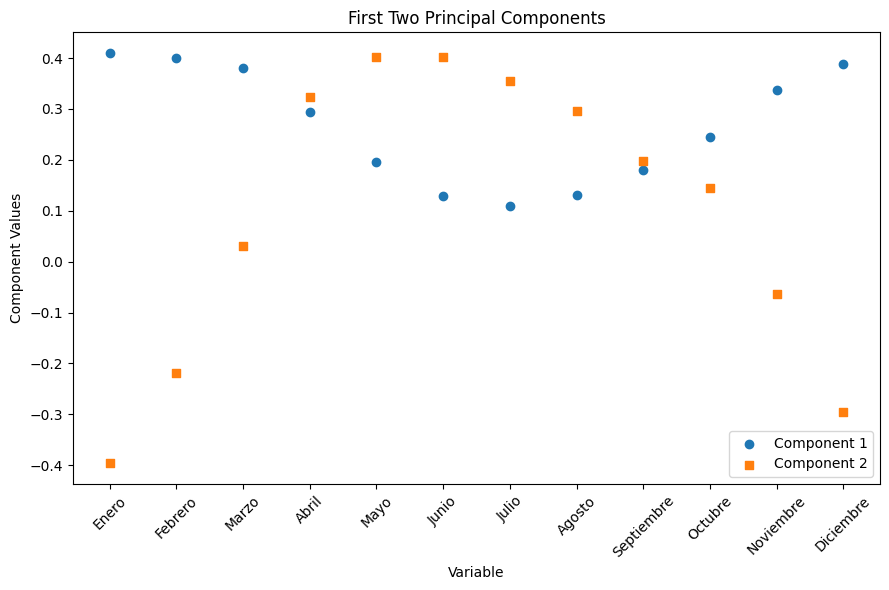

In [14]:
components = pca.components_
comp1 = components[0]
comp2 = components[1]
variables = d.columns.values  # Get variable names

plt.figure(figsize=(9, 6))

plt.scatter(variables, comp1, label='Component 1', marker='o')
plt.scatter(variables, comp2, label='Component 2', marker='s')

plt.title('First Two Principal Components')
plt.xlabel('Variable')
plt.ylabel('Component Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()

plt.tight_layout()
plt.show()


Vemos que el primer componente, que explica la mayor varianza, indica los meses asociados a una menor temperatura, mientras que el segundo componente indica los meses asociados a una mayor temperatura. Es decir, la mayor variaza en la temperatura ocurre en invierno, pues algunas regiones, especialmente en el norte, llegan a temperaturas extremadamente bajas, mientras que en verano, algunas regiones alcanzan temperaturas más altas que otras. Así mismo, notamos que el segundo componente también incluye valores negativos en invierno, dando a entender que las regiones donde se observan temperaturas altas en verano suele ser menos frío en invierno. Es decir, el primer vector promedia las temperaturas invernales, mientras que el segundo contrasta las invernales con las veraniegas.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(9, 6))
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

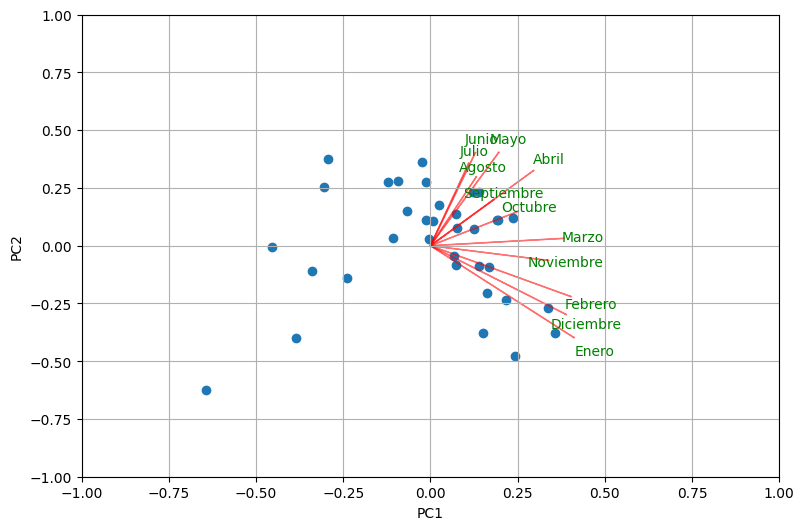

In [16]:
scores=pca.fit_transform(d)
myplot(scores[:,0:2],np.transpose(pca.components_[0:2, :]),labels=d.columns.values)

En el biplot, vemos que las estaciones forman una "V" igual que Canadá, pero en este caso está invertida hacia abajo. Recordemos que las direcciones principales no son únicas, pues menos la dirección mantiene todos los rquerimientos de PCA. Por esto, si la segunda componente fuera el negativo de la obtenida, podemos ver una semejanza con el mapa canadiense, con el primer componente explicando la diferencia entre las estaciones del este y del oeste, y la segunda los del norte con el sur.

### Ejercicio 3
En este ejercicio trabajamos con observaciones de una estación meteorológica en las Palomas a 10km de CIMAT sobre la carretera a Dolores Hidalgo entre 2003 y 2023. Nos limitamos a la temperatura y precipitación observada cada dos horas; hay muchisimos datos faltantes.

#### a)
Busca algunas visualizaciones informativas. No se trata de generar la máxima cantidad de gráficas y tratar de abarcar todos los aspectos, sino construir unas particularmente informativas alrededor de unas preguntas de interés que tú eliges. Escribe en palabras siempre lo que se puede concluir de las gráficas.

Puedes limitarte a un subconjunto de los datos. Toma en cuenta que contrario a la temperatura, la cantidad de precipitación es una variable mixta: puede ser 0 (es decir, discreto) o un valor positivo continuo. Conviene considerar los datos no como una sola serie de tiempo sino algo periódico

Iniciamos con la importación de las librerías necesarias y el cargado del dataset

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimpy import skim
import seaborn as sns

In [18]:
# Load the CSV file with the first column as the index
df = pd.read_csv('laspalomas.csv', index_col=0)

Eliminaremos la variable X pues es idéntica al nombre de cada observación, lo que no nos aporta información adicional. Obtenemos el mes y el año desde la fecha, y posteriormente eliminamos la variable fecha.


In [19]:
df = df.drop(columns=['X'], errors='ignore')

# Convert 'Fecha' to datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Mes'] = df['Fecha'].dt.month
df['Anno'] = df['Fecha'].dt.year

df = df.drop(columns=['Fecha'], errors='ignore')

Podemos ver ahora los datos:

In [20]:
df.head()

,Id_Estacion_id,Precipitacion,Temp_aire,Mes,Anno
1,11-0055,NaN,NaN,1,2003
2,11-0055,NaN,NaN,1,2003
3,11-0055,NaN,NaN,1,2003
4,11-0055,NaN,NaN,1,2003
5,11-0055,NaN,NaN,1,2003


Notamos que los datos contienen gran cantidad de valores nulos. Vamos a calcular el porcentaje de valores nulos en cada column.

In [21]:

nan_percentage = df.isna().mean() * 100

# Print the result
print(nan_percentage)

Id_Estacion_id     0.000000
Precipitacion      6.165836
Temp_aire         18.396003
Mes                0.000000
Anno               0.000000
dtype: float64


Si bien los valores nulos son significativos en las columnas de Precipitacion y Temperatura, procedemos a eliminarlos para continuar con el análisis.

In [22]:
df.dropna(inplace=True)

In [23]:
df.describe()

,Precipitacion,Temp_aire,Mes,Anno
count,72212.000000,72212.000000,72212.000000,72212.000000
mean,0.152645,14.772568,6.732662,2011.562164
std,1.307398,4.821990,3.535519,5.513021
min,0.000000,-2.800000,1.000000,2003.000000
25%,0.000000,11.600000,4.000000,2006.000000
50%,0.000000,14.100000,7.000000,2011.000000
75%,0.000000,18.200000,10.000000,2016.000000
max,113.540000,32.500000,12.000000,2023.000000


Como primer visualización, tomamos el promedio de precipitaciones por mes.

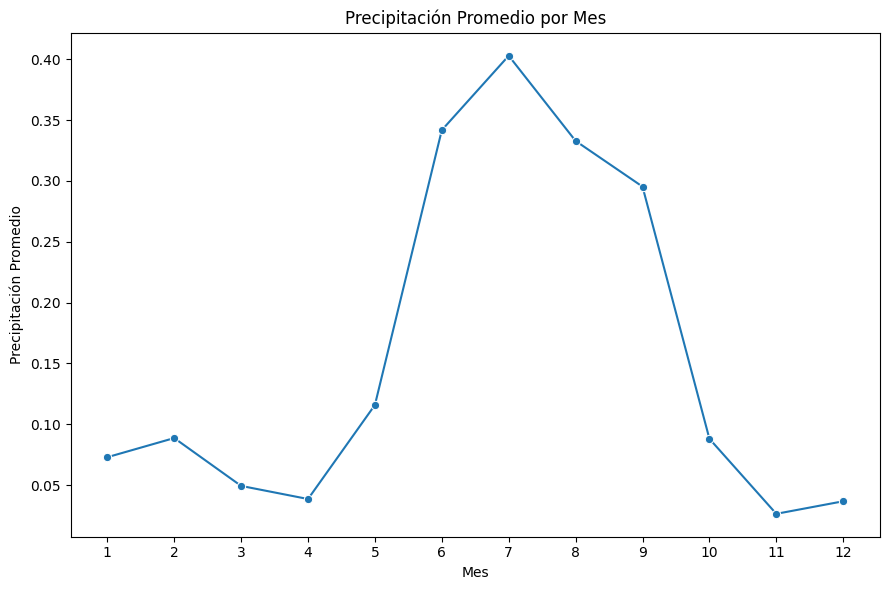

In [24]:
# Group by month and calculate the mean of Precipitacion for each month
monthly_precipitation = df.groupby('Mes')['Precipitacion'].mean()

# Create the plot
plt.figure(figsize=(9, 6))
sns.lineplot(x=monthly_precipitation.index, y=monthly_precipitation.values, marker='o')

# Customize the plot
plt.xlabel('Mes')
plt.ylabel('Precipitación Promedio')
plt.title('Precipitación Promedio por Mes')
plt.xticks(range(1, 13))  # Ensure x-axis shows all months from 1 to 12

# Show the plot
plt.tight_layout()
plt.show()


Notamos que, durante los meses de verano y otoño, las precipitaciones son más abundantes. Esto coincide con el conocimiento empírico de la temporada de lluvias en la región. Sin embargo, es interesante observar que durante los meses de invierno, también hay algunas precipitaciones. Procederemos con un boxplot de las precipitaciones por mes.

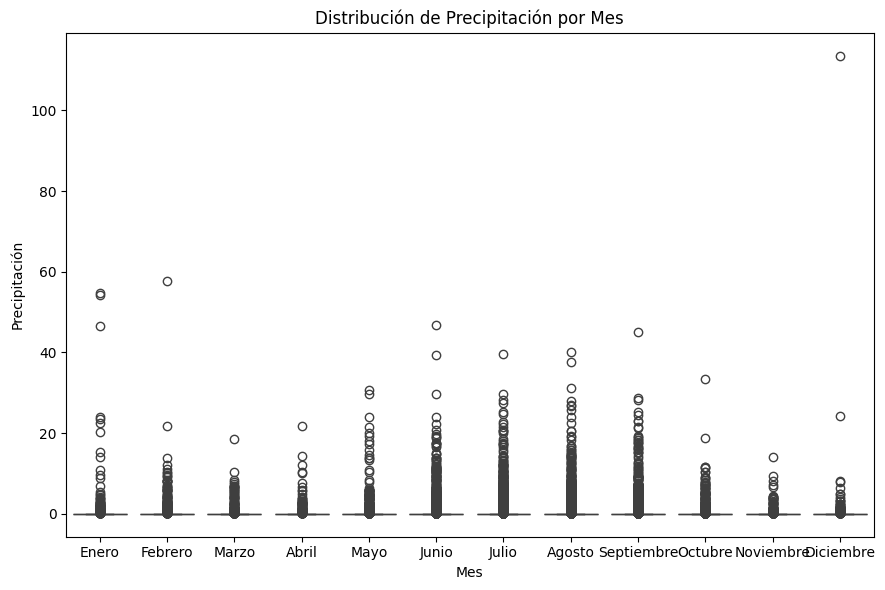

In [25]:
# Create the boxplot
plt.figure(figsize=(9, 6))
sns.boxplot(x='Mes', y='Precipitacion', data=df)

# Customize the plot
plt.xlabel('Mes')
plt.ylabel('Precipitación')
plt.title('Distribución de Precipitación por Mes')
plt.xticks(range(12), ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
                       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])

# Show the plot
plt.tight_layout()
plt.show()


Notamos que la incidencia de ceros en el nivel de precipitación lleva a las cajas a estar concentradas en cero, sin embargo observamos que durante la temporada de lluvias, las precipitaciones son más intensas y más frecuentes.

Seguimos con la temperatura promedio por mes.

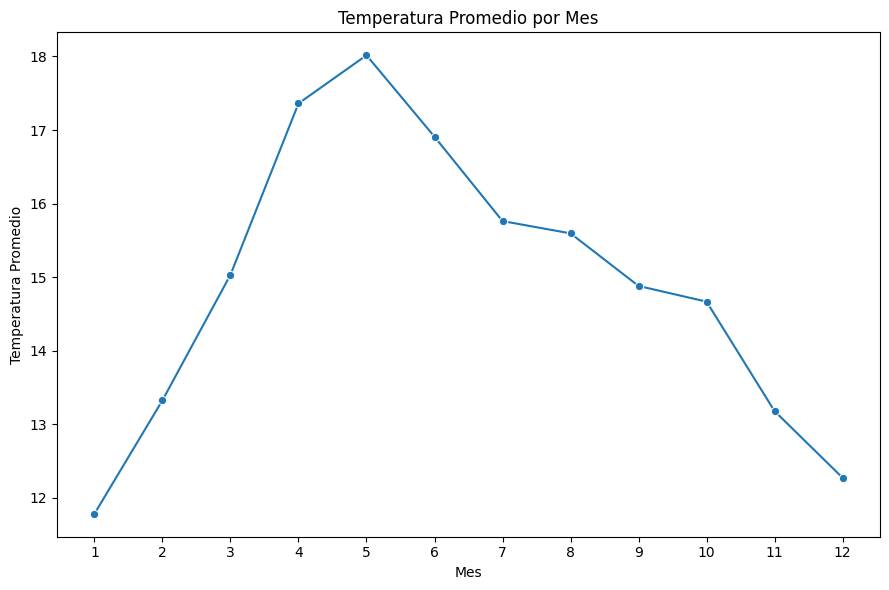

In [26]:
# Group by Month and calculate the mean of Precipitacion for each month
monthly_temperature = df.groupby('Mes')['Temp_aire'].mean()

# Create the plot
plt.figure(figsize=(9, 6))
sns.lineplot(x=monthly_temperature.index, y=monthly_temperature.values, marker='o')

# Customize the plot
plt.xlabel('Mes')
plt.ylabel('Temperatura Promedio')
plt.title('Temperatura Promedio por Mes')
plt.xticks(range(1, 13))  # Ensure x-axis shows all months from 1 to 12

# Show the plot
plt.tight_layout()
plt.show()

Notamos que, en promedio, la mayor temperatura promedio se registra durante la primavera, mientras que la menor se registra durante el invierno. Resulta extraño que la mayor temperatura promedio no sea registrada durante el verano, sin embargo es posible que esto se deba a alguna relación entre la temperatura y las precipitaciones, de forma que las precipitaciones registradas en temporada de lluvias bajen la temperatura durante estos meses. Procedemos con un boxplot para confirmar empíricamente esta suposición.

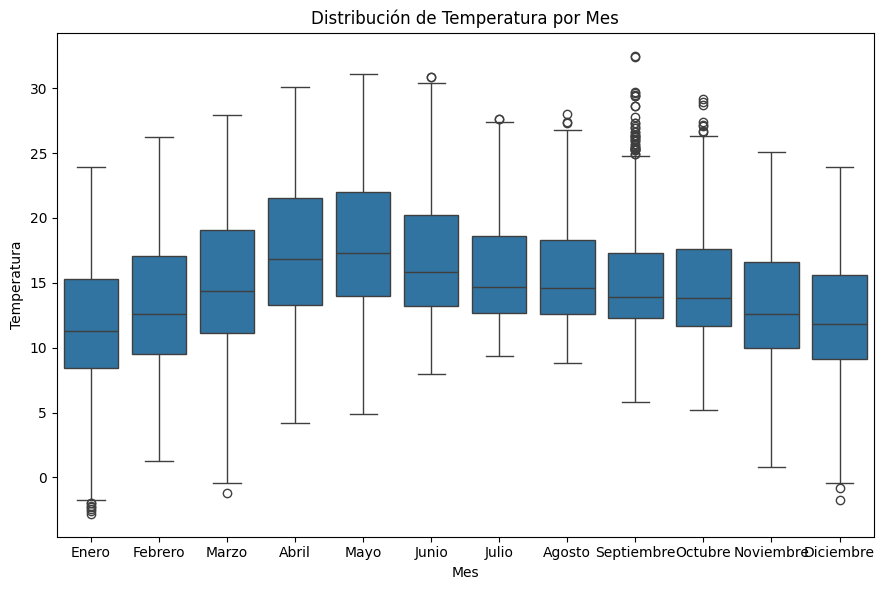

In [27]:
# Create the boxplot
plt.figure(figsize=(9, 6))
sns.boxplot(x='Mes', y='Temp_aire', data=df)

# Customize the plot
plt.xlabel('Mes')
plt.ylabel('Temperatura')
plt.title('Distribución de Temperatura por Mes')
plt.xticks(range(12), ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
                       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])

# Show the plot
plt.tight_layout()
plt.show()


Notamos que la suposición se confirma empíricamente, pues el intervalo superior durante los meses de verano es mucho mayor hacia las temperaturas más altas que el resto del año, incluso en septiembre se registran algunas de las temperaturas más altas, pero estas se encuentran como valores atípicos. De hecho, el intervalo inferior alcanza el máximo en julio, mientras que el intervalo superior lo hace en mayo.

Finalmente, presentamos un scatter plot de la temperatura y el nivel de precipitaciones para observar la relación entre estas dos variables.

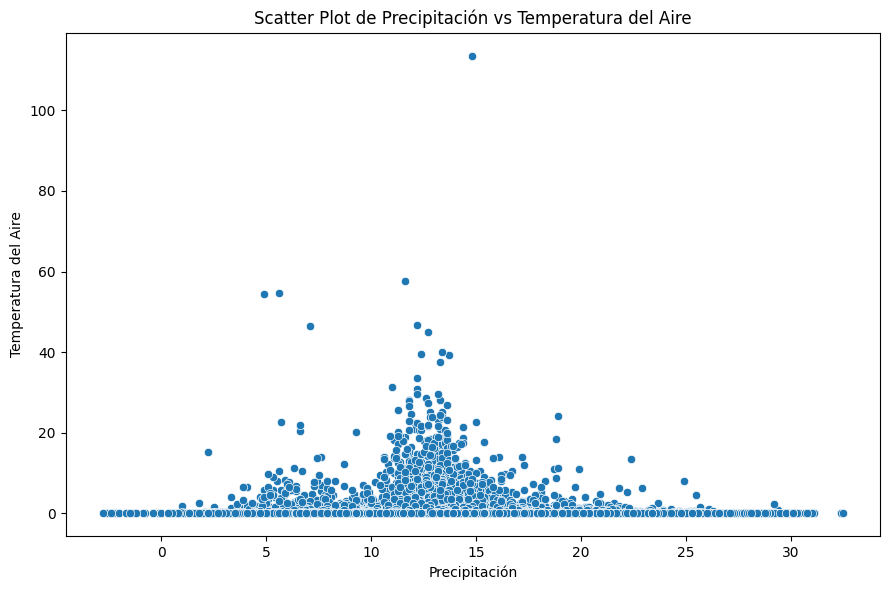

In [28]:
# Create the scatter plot
plt.figure(figsize=(9, 6))
sns.scatterplot(x='Temp_aire', y='Precipitacion', data=df)

# Customize the plot
plt.xlabel('Precipitación')
plt.ylabel('Temperatura del Aire')
plt.title('Scatter Plot de Precipitación vs Temperatura del Aire')

# Show the plot
plt.tight_layout()
plt.show()

Notamos que parece existir una relación entre la temperatura y el nivel de precipitaciones, sin embargo, la relación no es lineal, pues no hay alta frecuencia de precipitaciones cuando la temperatura es muy alta o baja.

#### b)
Usa PCA para entender mejor (parte de) las observaciones de temperatura. Hay varias maneras para plantear un problema de PCA a partir de los datos. Tú decides qué elegir. Escribe en palabras siempre lo que se puede concluir. Toma en cuenta que son datos reales con muchas deficiencias. Dejate inspirar por el ejercicio anterior con los datos de Canada.

Ahora, consideramos solamente los valores numéricos del dataframe, de forma que perdemos el ID de la estación.

In [29]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

print(numerical_df.head())  # Check the first few rows


     Precipitacion  Temp_aire  Mes  Anno
421           2.03       12.0    8  2003
422           0.51       12.1    8  2003
423           0.00       13.0    8  2003
424          14.48       11.2    8  2003
425          13.72       11.1    8  2003


In [30]:
skim(numerical_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 72212  │ │ float64     │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA  ┃ NA %   ┃ mean     ┃ sd      ┃ p0     ┃ p25    ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Precipitacion     │   0 │      0 │   0.1526 │   1.307 │      0 │      0 │     0 │     0 │  113.5 │    ▇    │  │
│ │ Temp_aire         │   0 │      0 │    14.77 │   4.822 │   -2.8 │   11.6 │  14.1 │  18.2 │   32.5 │   ▂▇▅▂  │  │
│ │ Mes               │   0 │      0 │    6.733 │   3.536 │      1 │      4 │     7 │    10 │     12 │ ▇▆▆▇▇▇  │  │
│ │ Anno              │   0 │      0 │     2012 │   5.513 │   2003 │   2006 │  2011 │  2016 │   2023 │ ▇▃▅▇▃▃  │  │
│ └───────────────────┴─────┴────────┴──────────┴─────────┴────────┴────────┴───────┴───────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Estandarizamos los datos para el análisis de componentes principales.

In [31]:
scaler = StandardScaler()

# Standardize the numerical data
numerical_df_standardized = pd.DataFrame(scaler.fit_transform(numerical_df), 
                                         columns=numerical_df.columns, 
                                         index=numerical_df.index)

print(numerical_df_standardized.head())  # Check the first few rows


     Precipitacion  Temp_aire       Mes      Anno
421       1.435957  -0.574988  0.358461 -1.553091
422       0.273335  -0.554250  0.358461 -1.553091
423      -0.116756  -0.367604  0.358461 -1.553091
424      10.958755  -0.740896  0.358461 -1.553091
425      10.377443  -0.761634  0.358461 -1.553091


In [32]:
pca=PCA(2) # se puede especificar máximo número de componentes o % varianza explicada que se quiere alcanzar

In [33]:
pca.fit(numerical_df_standardized)

PCA(n_components=2)

In [34]:
#https://python-for-multivariate-analysis.readthedocs.io/a_little_book_of_python_for_multivariate_analysis.html

def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

Los dos primeros componentes explican apenas el 53% de la varianza de los datos.

In [35]:
pca_summary(pca, numerical_df_standardized)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.051078,0.276191,0.276191
PC2,1.015517,0.257819,0.534010


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.051078,0.276191,0.276191
PC2,1.015517,0.257819,0.534010


Ahora, veamos qué variables están más relacionadas con cada uno de los componentes principales. Para esto, vamos a graficar las dos primeras componentes principales y ver qué variables están más cerca del origen (cercanas a cero) o lejos del mismo (lejanas a cero). Esto nos dará una idea de qué variables están más relacionadas con cada componente principal.

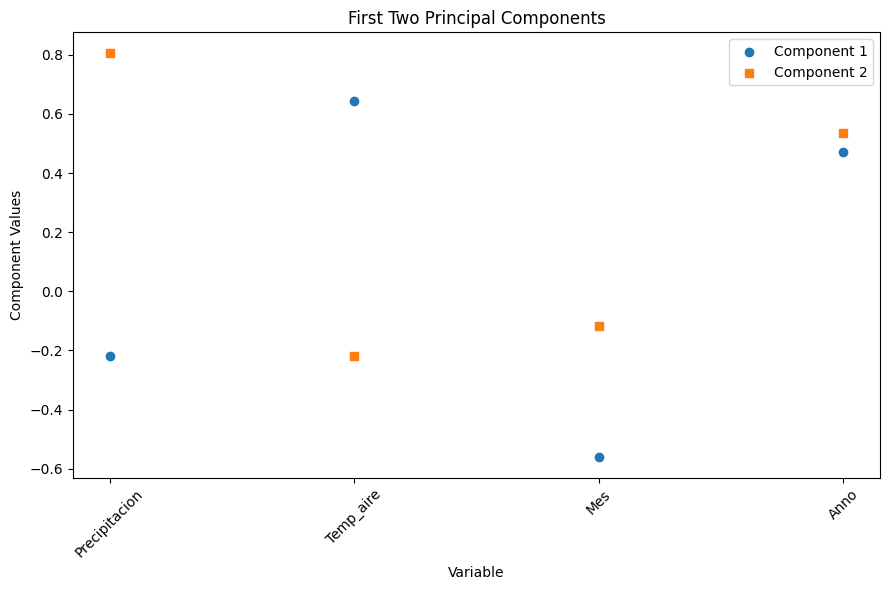

In [36]:
components = pca.components_
comp1 = components[0]
comp2 = components[1]
variables = numerical_df.columns.values  # Get variable names

plt.figure(figsize=(9, 6))

plt.scatter(variables, comp1, label='Component 1', marker='o')
plt.scatter(variables, comp2, label='Component 2', marker='s')

plt.title('First Two Principal Components')
plt.xlabel('Variable')
plt.ylabel('Component Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()

plt.tight_layout()
plt.show()


Los componentes principales, en este caso, no son de gran información útil para entender la relación entre las variables. Esto puede deberse a que ña posible relación entre Temperatura y Precipitación parece no ser lineal, y PCA identifica relaciones lineales. El primer componente principal hace un promedio del año y de las temperatura del aire, mientras que el segundo hace un contraste entre las mismas variables. Esto se puede ver claramente a continuación, en el biplot.

In [37]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

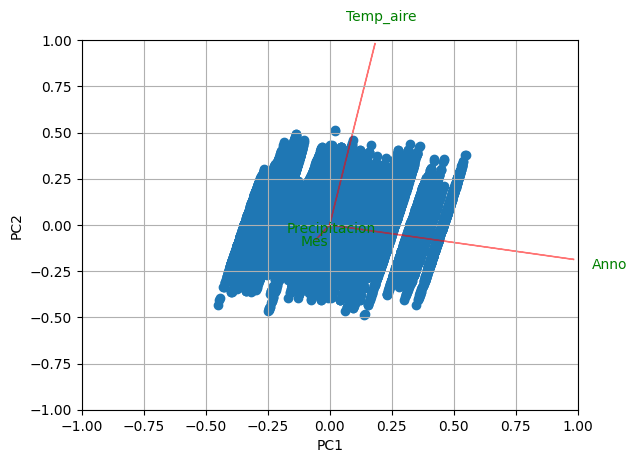

In [38]:
scores=pca.fit_transform(numerical_df)
myplot(scores[:,0:2],np.transpose(pca.components_[0:2, :]),labels=numerical_df.columns.values)

Podríamos repetir este análisis eliminando el mes y el año como variables, pero obtendríamos que las componentes son casi idénticas a los vectores canónicos. Esto sugiere que la relación entre las variables no es lineal, como lo dijimos anteriormente. Podríamos utilizar otras técnicas que serán estudiadas más adelante para compensar esta situación.

### Ejercicio 5
Supongamos que se decide hacer PCA para los siguientes datos pero sin centrar los datos, es decir, no trabajar con la estimacion de $\operatorname{Cov}(X)$ sino de $\mathbb{E}X^\top X$ (como si $\mathbb{E}X$ fuera 0):

<div style="text-align:center;">
  <img src="Figures\datos.png" alt="Datos no centrados" width="35%" height="auto">
</div>


Dibuja aproximadamente el primer componente principal que se obtendrá.

¿Crees que el segundo componente coincide con el primer componente de los datos centrados?

A continuación mostramos la estimación de la primer componente principal. No centrar los datos nos lleva a una dirección casi ortogonal que la que debió ser elegida. El segundo componente parece coincidir en este caso, pero no siempre lo hará. Por ejemplo, si los datos estuvieran arriba en vez de al lado, las componentes parecerían los vectores canónicos.

<div style="text-align:center;">
  <img src="Figures\estimacion.png" alt="Datos no centrados" width="35%" height="auto">
</div>
